# School test results: analysis

The aim here was to explore how school tests results in Maths and Portuguese (in Portugese schools) are impacted by demographic factors, if at all, and to look into which other features drive school test results. 

The dataset provided contains several demographic features, such as age, sex, family size, health and information about parental status and occupations. It also contains non-demographic features relating to school, study time, past failures and activities outside of school. These are all provided alongside three sets of school test results ('G1', 'G2' and 'G3'). 

First, an ETL (Extract-Transform-Load), exploratory data analysis and preprocessing steps are performed on the dataset. In these steps, the data is read into the notebook and cleaned, and some initial visualisations are created.

Next, some machine learning models are trained and evaluated to try and determine whether school test results are impacted by demographic factors. A few different models and modelling techniques are explored here, in an attempt to reduce overfitting.

Finally, a model explainability technique known as SHAP is used to look at which features do actually drive school test results, and what their impact is.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
import xgboost
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
import shap
import copy

### ETL

In [2]:
df = pd.read_csv('data/student-por.csv')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
df.shape

(649, 33)

In [5]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [6]:
#look at breakdown of categorical variables
for col in df.columns:
    if df[col].dtype == 'O':
        print(col, df[col].unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes']


In [7]:
#convert columns with only 'yes' and 'no' values to boolean
yes_no_to_bool = {'yes':True, 'no':False}
for col in df.columns:
    if 'yes' in df[col].unique():
        df[col] = df[col].map(yes_no_to_bool)  

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [8]:
#convert 'unknown' and 'other' values
#note that 'Other' as in the 'gender' column is not converted here
convert_to_null_dict = {'other':np.nan, 'unknown':0}

df = df.replace(convert_to_null_dict)

In [9]:
#convert numbers written as strings to numeric
df['freetime'] = df['freetime'].astype(int)

In [10]:
#one-hot encode remaining categorical variables
df = pd.get_dummies(df)

### Exploratory data analysis

In [11]:
#look at key characteristics
pd.options.display.max_columns = df.shape[1]
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,guardian_father,guardian_mother
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.00000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009,0.651772,0.348228,0.590139,0.409861,0.303544,0.696456,0.704160,0.295840,0.123267,0.876733,0.208012,0.073960,0.209553,0.11094,0.064715,0.035439,0.278891,0.055470,0.439137,0.229584,0.220339,0.235747,0.701079
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656,0.476776,0.476776,0.492187,0.492187,0.460143,0.460143,0.456771,0.456771,0.328996,0.328996,0.406199,0.261908,0.407304,0.31430,0.246212,0.185030,0.448799,0.229072,0.496665,0.420890,0.414795,0.424792,0.458138
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'Medu'}>,
        <AxesSubplot: title={'center': 'Fedu'}>,
        <AxesSubplot: title={'center': 'traveltime'}>,
        <AxesSubplot: title={'center': 'studytime'}>,
        <AxesSubplot: title={'center': 'failures'}>],
       [<AxesSubplot: title={'center': 'famrel'}>,
        <AxesSubplot: title={'center': 'freetime'}>,
        <AxesSubplot: title={'center': 'goout'}>,
        <AxesSubplot: title={'center': 'Dalc'}>,
        <AxesSubplot: title={'center': 'Walc'}>,
        <AxesSubplot: title={'center': 'health'}>],
       [<AxesSubplot: title={'center': 'absences'}>,
        <AxesSubplot: title={'center': 'G1'}>,
        <AxesSubplot: title={'center': 'G2'}>,
        <AxesSubplot: title={'center': 'G3'}>,
        <AxesSubplot: title={'center': 'school_GP'}>,
        <AxesSubplot: title={'center': 'school_MS'}>],
       [<AxesSubplot: title={'center': 'sex_F'}>,
        <AxesSubplot: title={'cent

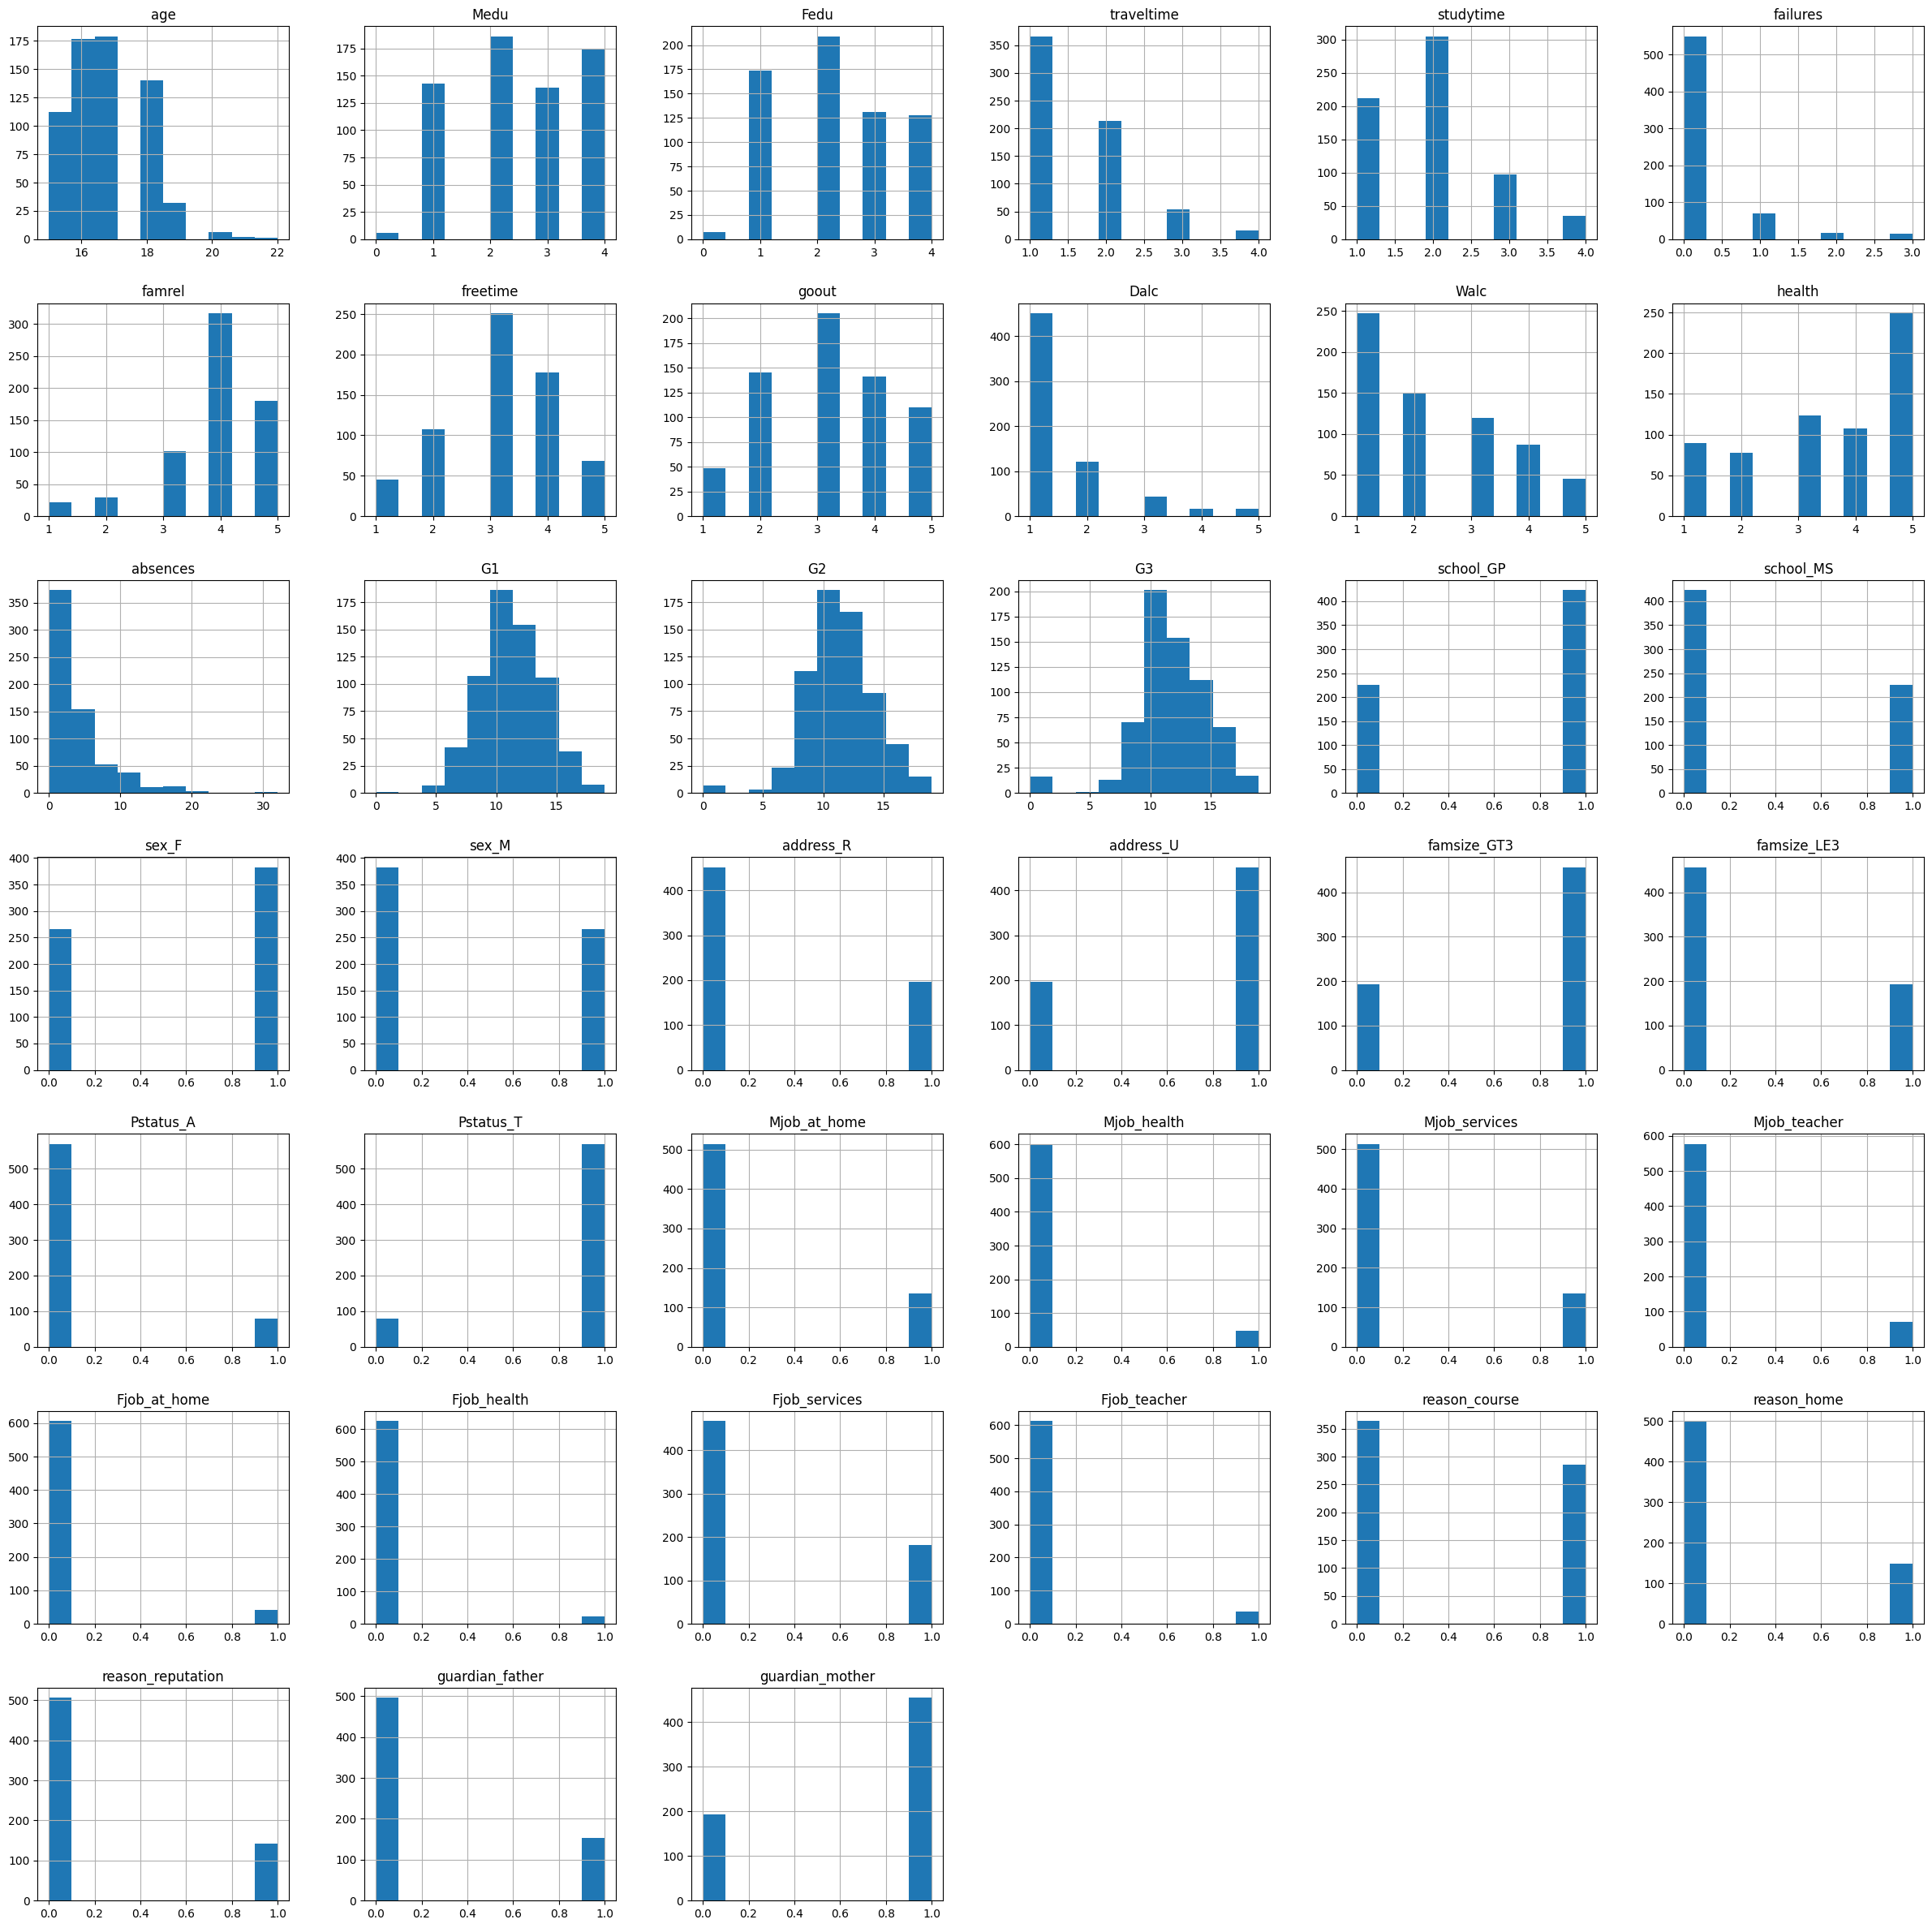

In [12]:
#look at distributions
df.hist(figsize=(30,30))

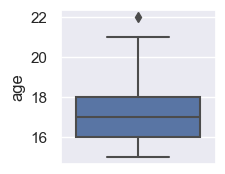

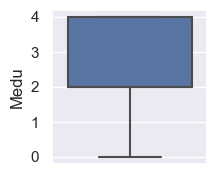

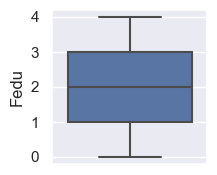

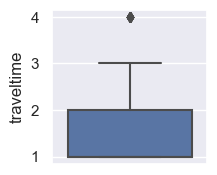

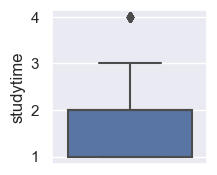

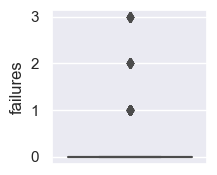

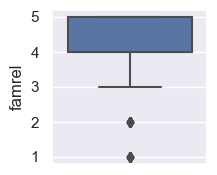

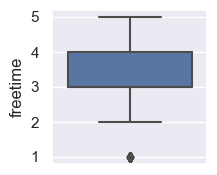

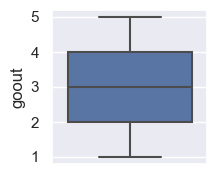

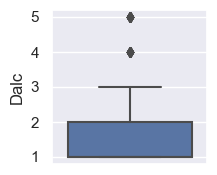

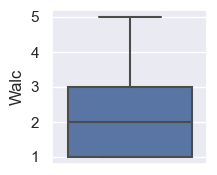

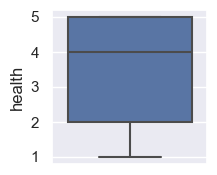

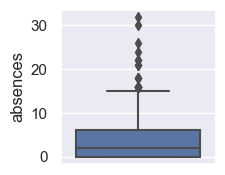

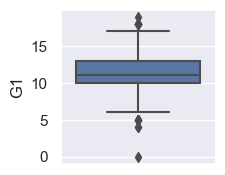

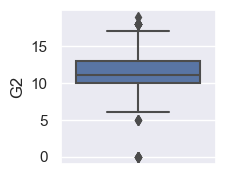

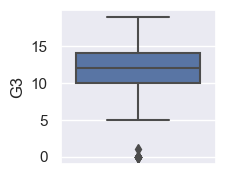

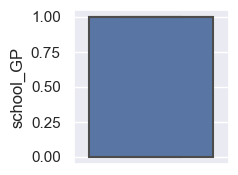

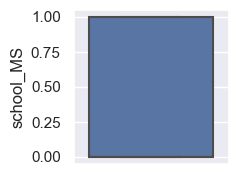

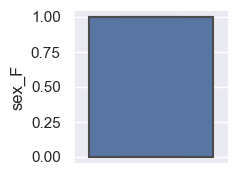

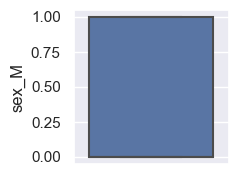

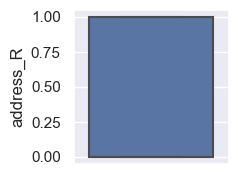

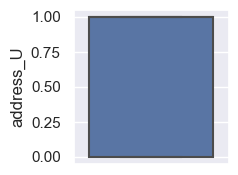

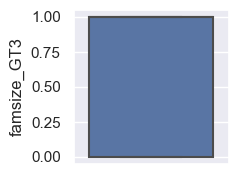

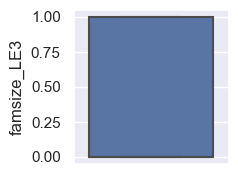

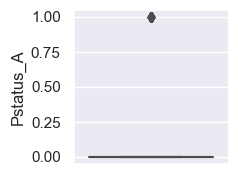

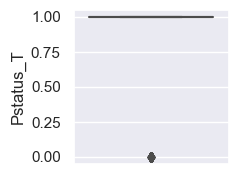

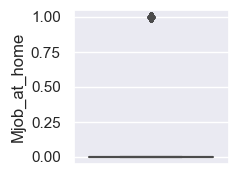

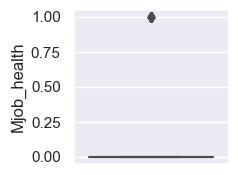

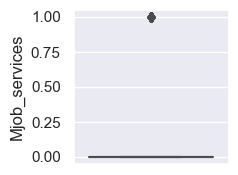

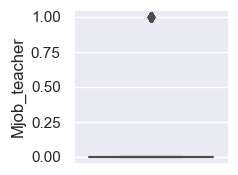

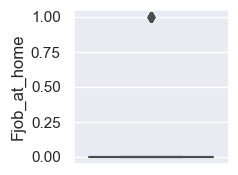

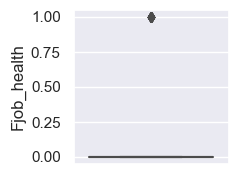

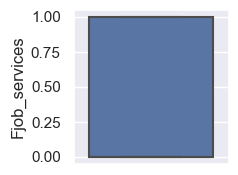

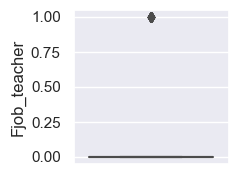

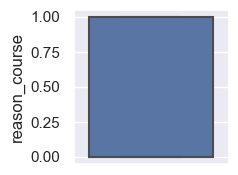

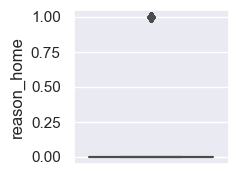

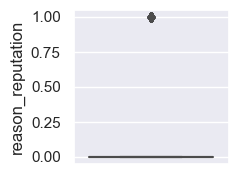

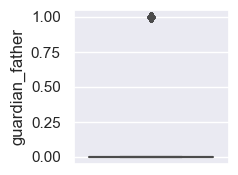

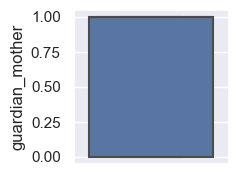

In [13]:
#create boxplots to see outliers better 
sns.set(rc={'figure.figsize':(2, 2)})
for col in df[df.describe().columns].columns:
    sns.boxplot(data=df, y=col, orient='v')
    plt.show()

<AxesSubplot: >

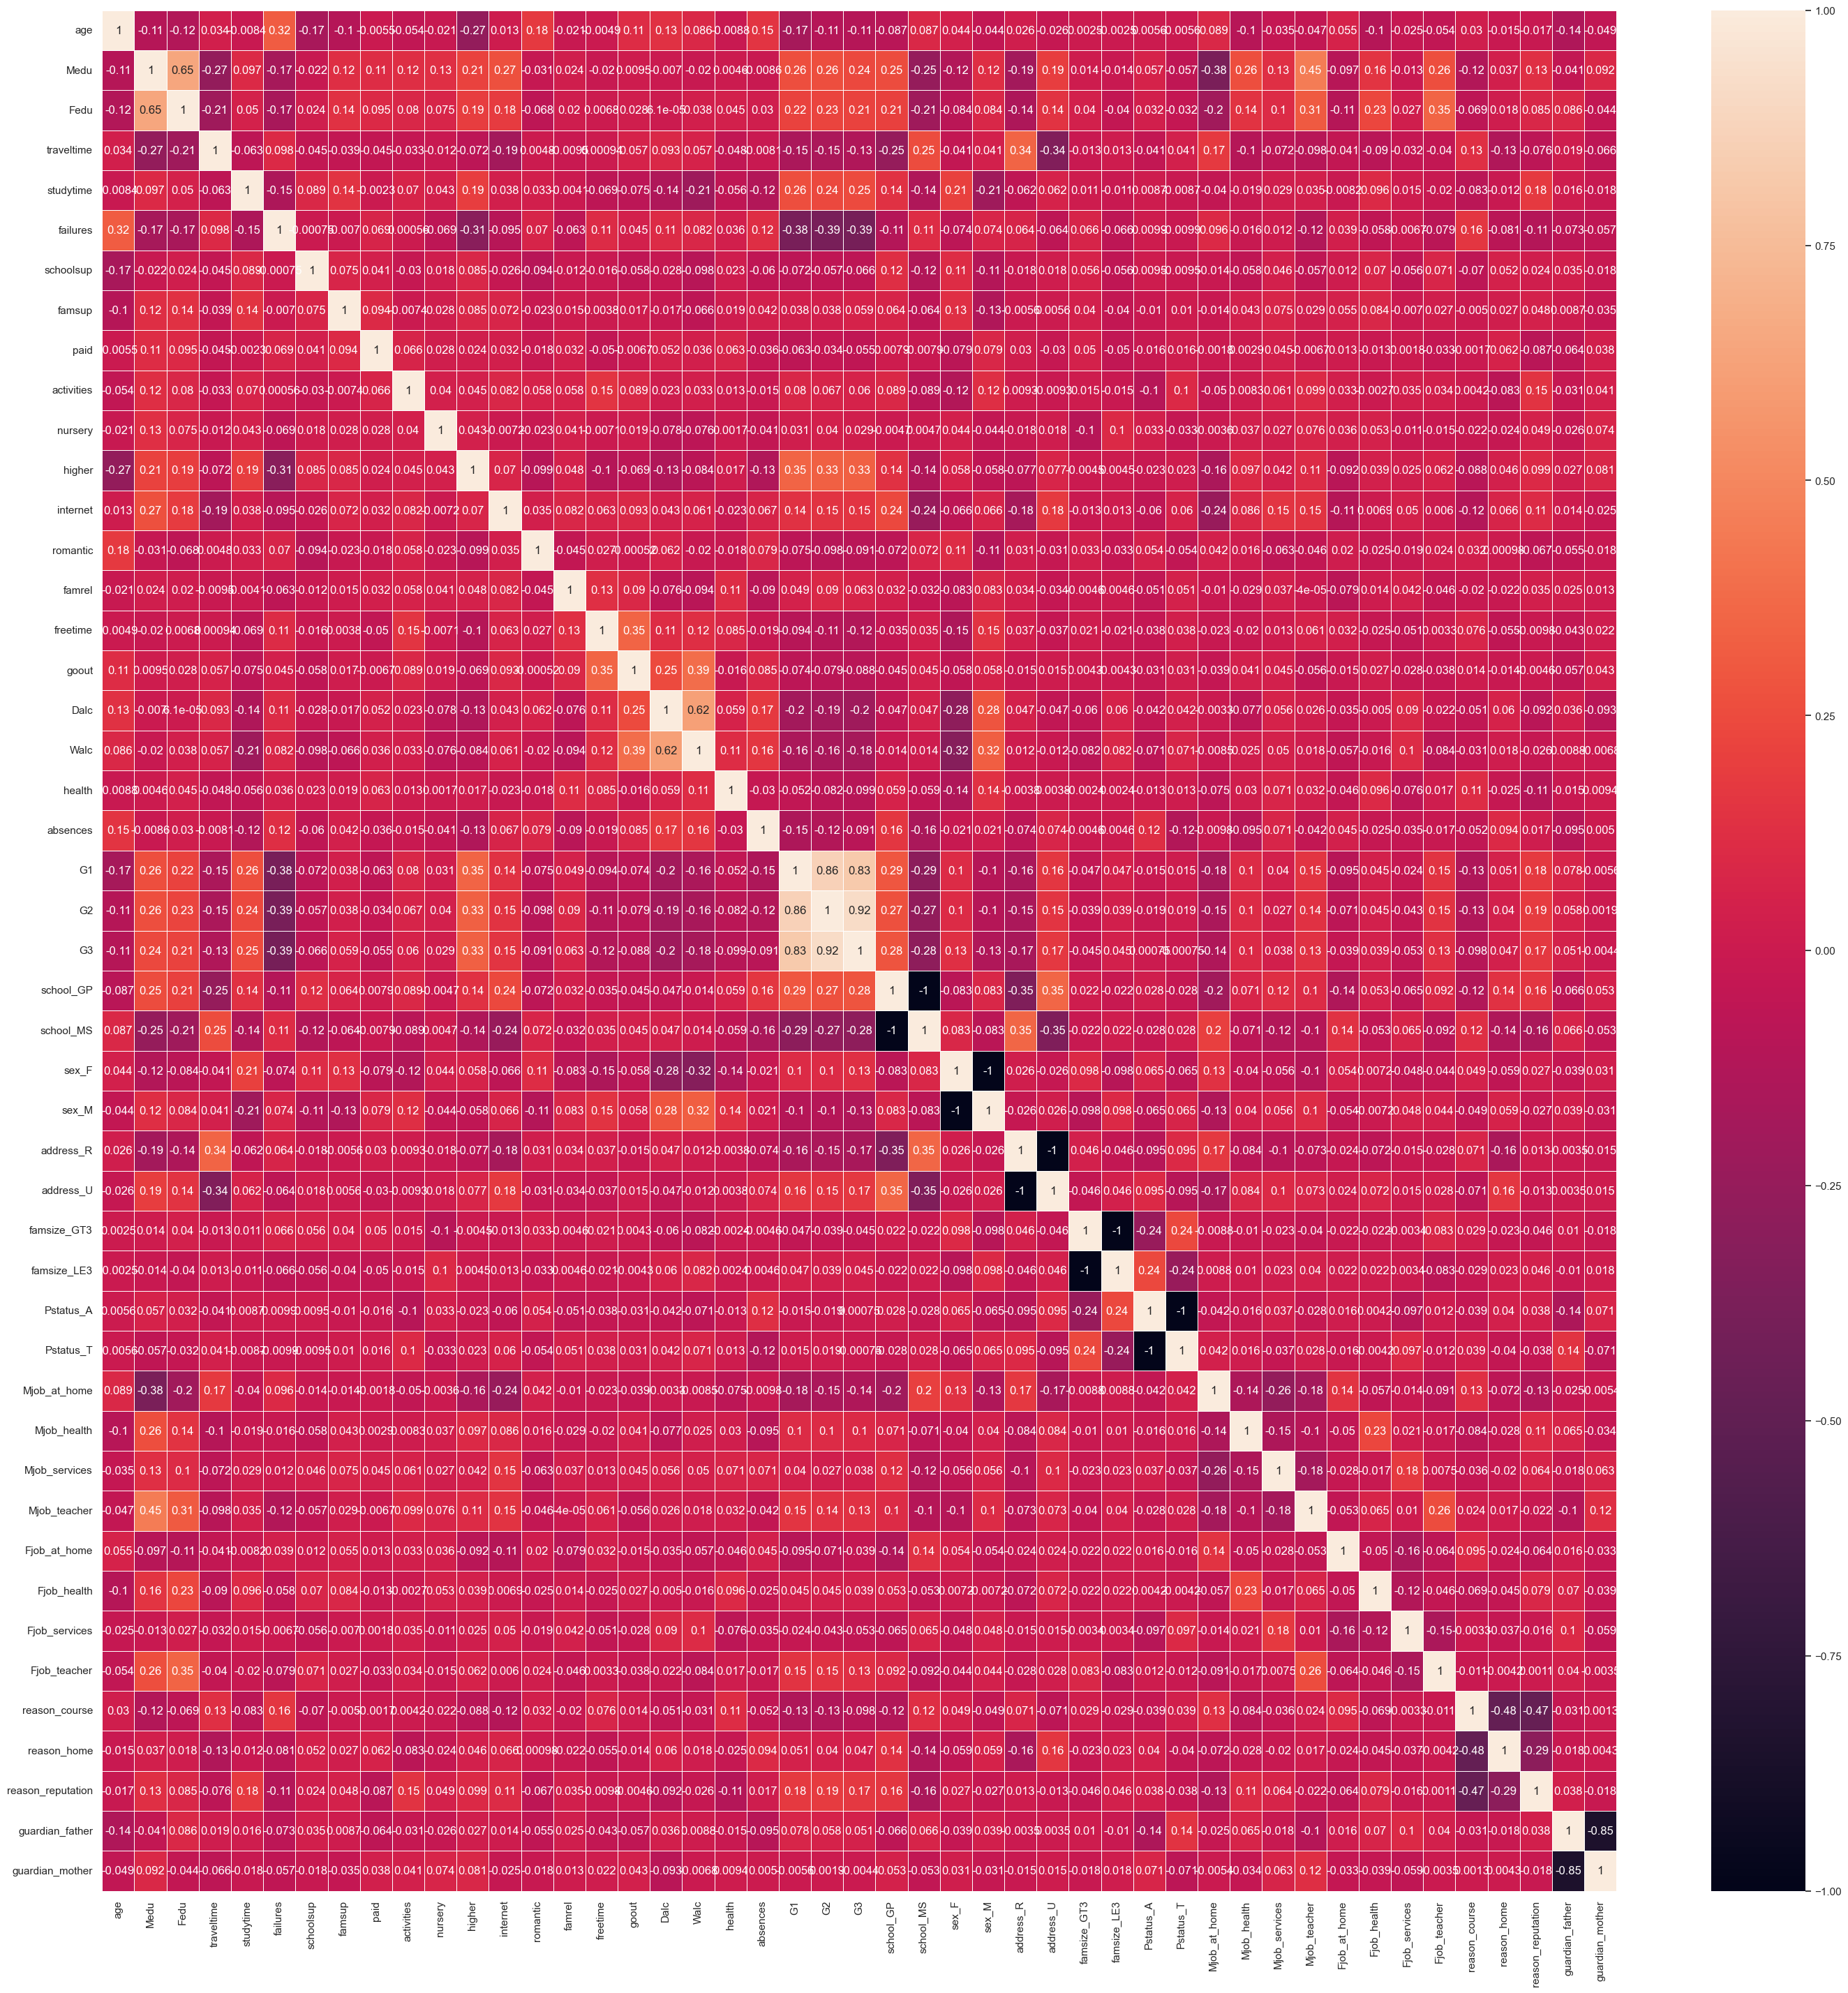

In [14]:
#look at correlations between variables
corr = df.corr()

fig, ax = plt.subplots(figsize=(35,35))
sns.heatmap(corr, fmt='.2g', annot=True, linewidths=.5, ax=ax)

### Preprocessing (based on EDA)

The lowest value in the 'failures' column is -1 (shown by the boxplots and distributions). It would be useful to investigate this further if possible, but for now, I'm going to set this value as 0, since it seems counter-intuitive to have -1 failures. It's possible this is a data issue, and I don't want the model to be negatively impacted.

In [15]:
#make negative values 0 in 'failures' column
df.loc[df['failures']<0, 'failures'] = 0

It seems that the majority of people have had very few absences - 75% of the dataset have had 8 or less. I'm going to cap those who had more than 20 absences at 20.

In [16]:
df.loc[df['absences']>20, 'absences'] = 20

As a result of the one-hot encoding, there are some columns where (almost) exactly the same thing is already represented in another column, and the correlation coefficient is very high as a result (1 or close to 1). 

I've also isolated certain columns that are highly correlated with other columns in the dataframe (correlation coefficient >= 0.4). Either or both of these may be removed during feature selection.

In [17]:
#columns where (almost) exactly the same thing is already represented in another column
duplicated_cols = ['school_GP', 
                   'sex_M', 
                   'address_U', 
                   'famsize_LE3', 
                   'Pstatus_T',
                   'guardian_father']

#other highly correlated cols, where correlation >= 0.4
high_corr_cols = ['reason_course', 
                  'Fedu',
                  'Walc', 
                  'Mjob_at_home']

### Are school test results impacted by demographic factors?

The aim here is to create a model based on purely demographic factors, and assess whether these demographic factors do have an impact on test results.

In [18]:
df.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'school_GP', 'school_MS',
       'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3',
       'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_reputation', 'guardian_father', 'guardian_mother'],
      dtype='object')

In [19]:
#isolate demographic features 
dem_feats = ['age', 
             'Medu', #mother's education level
             'Fedu', #father's education level
             'sex_F', 
             'sex_M',
             'famrel', #family relationships
             'health',
             'famsize_GT3', #family size greater than 3
             'famsize_LE3', #family size less than 3
             'Pstatus_A', #parents live apart 
             'Pstatus_T', #parents live together
             'Mjob_at_home', #mother's job: at home
             'Mjob_health', #mother's job: health
             'Mjob_services', #mother's job: services
             'Mjob_teacher',#mother's job: teacher
             'Fjob_at_home', #father's job: at home
             'Fjob_health', #father's job: health
             'Fjob_services', #father's job: services
             'Fjob_teacher', #father's job: teacher
             'guardian_father',
             'guardian_mother',
             'address_R', #address rural
             'address_U', #address urban
             'famsup', #family educational support
             'internet', #internet access at home
             'nursery' #whether they went to nursery
             ]

#### Baseline model

In [20]:
X = df[dem_feats]
y = df[['G1', 'G2', 'G3']]

In [21]:
df.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'school_GP', 'school_MS',
       'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3',
       'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_reputation', 'guardian_father', 'guardian_mother'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [23]:
pipe = Pipeline([('lr', LinearRegression())])


In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('lr', LinearRegression())])

In [25]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [26]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred, model_label: str):
    '''Prints R2 and MAE for training and testing sets.'''
    print(f'\n\n{model_label} training dataset R\u00b2: {r2_score(y_train, y_train_pred)}')
    print(f'{model_label} training dataset MAE: {mean_absolute_error(y_train, y_train_pred)}')

    print(f'\n{model_label} test dataset R\u00b2: {r2_score(y_test, y_test_pred)}')
    print(f'{model_label} test dataset MAE: {mean_absolute_error(y_test, y_test_pred)}')

In [27]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled demographic')



Linear regression scaled demographic training dataset R²: 0.16470824400107018
Linear regression scaled demographic training dataset MAE: 2.0821625428827315

Linear regression scaled demographic test dataset R²: 0.09995842132364981
Linear regression scaled demographic test dataset MAE: 1.9567301265915615


In [28]:
def ave_plot(actual_data, expected_data, model_label: str):
    '''Plots actual vs. expected score, where expected score is score predicted by model.
       Plots line where actual score = expected score.
       Plots horizontal line showing mean value for actual score(s).'''
    
    #calculate mean for actuals
    actual_data_mean = actual_data.mean()
    #if using multiple scores as target variable, calculate the mean of the three mean scores
    if type(actual_data_mean) != np.float64:
        actual_data_mean = actual_data_mean.mean()
    
    #plot actual vs. expected socre
    plt.figure(figsize=(5,3))
    plt.scatter(actual_data, expected_data, s=2)
    
    #plot line where actual = expected
    plt.plot([0,20],[0,20],c='purple')
    
    #plot horizontal line showing mean value for actual score
    plt.plot(range(0, 20), (np.zeros(20)+actual_data.mean().mean()), c='red')
    
    plt.xlabel('Actual test score')
    plt.ylabel('Expected test score')
    plt.title(f'{model_label}')

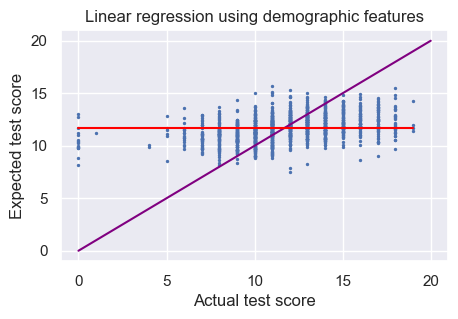

In [29]:
ave_plot(y_train, y_train_pred, 'Linear regression using demographic features')

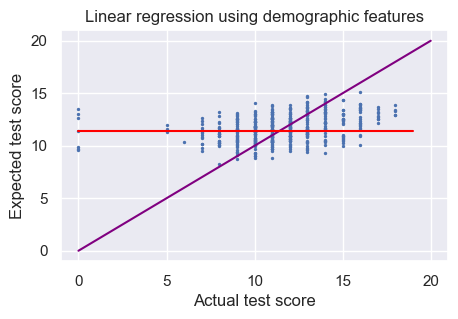

In [30]:
ave_plot(y_test, y_test_pred, 'Linear regression using demographic features')

#### Linear regression (with scaling)

In [31]:
X = df[dem_feats]
y = df[['G1', 'G2', 'G3']]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [33]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [35]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [36]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled demographic')



Linear regression scaled demographic training dataset R²: 0.16314991126883002
Linear regression scaled demographic training dataset MAE: 2.0858136660346616

Linear regression scaled demographic test dataset R²: 0.10054360232167932
Linear regression scaled demographic test dataset MAE: 1.95901882310318


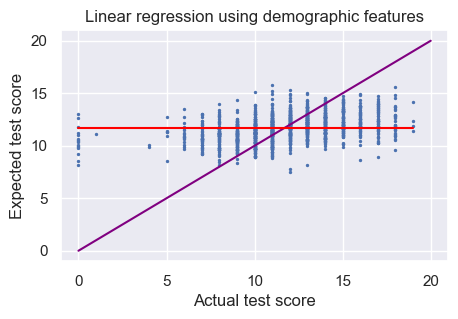

In [37]:
ave_plot(y_train, y_train_pred, 'Linear regression using demographic features')

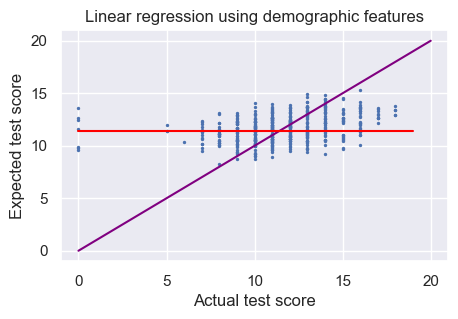

In [38]:
ave_plot(y_test, y_test_pred, 'Linear regression using demographic features')

#### Linear regression (with feature selection and scaling)

Feature selection is used here to remove highly correlated features and duplicated features.

In [39]:
X = df[[col for col in dem_feats if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [41]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [42]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [43]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [44]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled demographic feat_sel')



Linear regression scaled demographic feat_sel training dataset R²: 0.15903042534293155
Linear regression scaled demographic feat_sel training dataset MAE: 2.092763926696964

Linear regression scaled demographic feat_sel test dataset R²: 0.0869374897871426
Linear regression scaled demographic feat_sel test dataset MAE: 1.9727394618821663


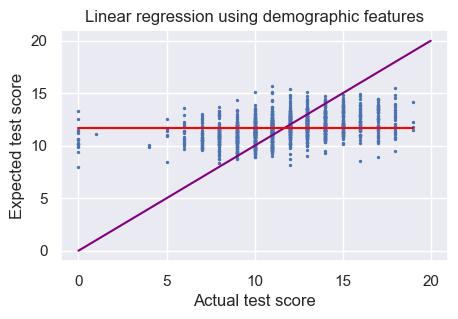

In [45]:
ave_plot(y_train, y_train_pred, 'Linear regression using demographic features')

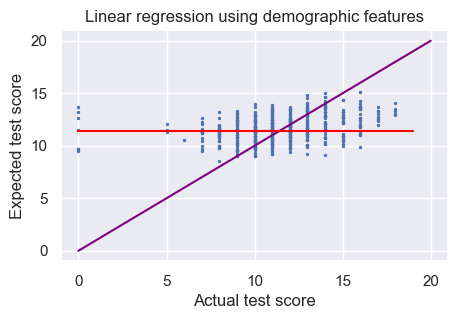

In [46]:
ave_plot(y_test, y_test_pred, 'Linear regression using demographic features')

#### Linear regression (with selection of fewer features and scaling)

The model appears to be overfitting. I'll attempt to reduce this by using far fewer features.

In [47]:
#find best threshold to use for selecting features based on their correlation coefficient with the target variable
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('lr', LinearRegression())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.01 or more with any of the target variables is used. R² score achieved is 0.08696318147804516


In [48]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800
Mjob_at_home,0.176965,0.151208,0.136778
age,0.174322,0.107119,0.106505
address_U,0.157127,0.154600,0.167637
address_R,0.157127,0.154600,0.167637
Mjob_teacher,0.148925,0.136419,0.134910
Fjob_teacher,0.146338,0.146767,0.125916
internet,0.139931,0.147909,0.150025
sex_M,0.104109,0.104005,0.129077


In [49]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [51]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [52]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [53]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [54]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled demographic feat_sel')



Linear regression scaled demographic feat_sel training dataset R²: 0.15733140485577302
Linear regression scaled demographic feat_sel training dataset MAE: 2.0918929970934474

Linear regression scaled demographic feat_sel test dataset R²: 0.08696318147804516
Linear regression scaled demographic feat_sel test dataset MAE: 1.97009973457832


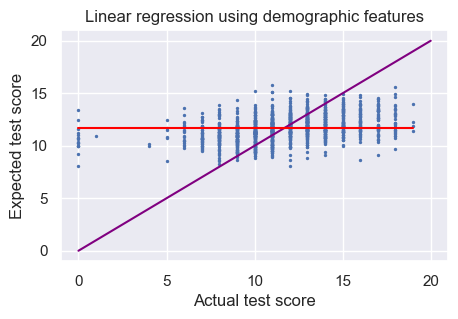

In [55]:
ave_plot(y_train, y_train_pred, 'Linear regression using demographic features')

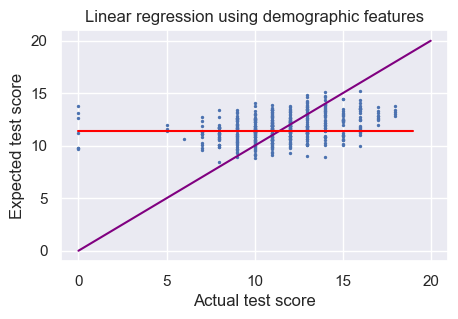

In [56]:
ave_plot(y_test, y_test_pred, 'Linear regression using demographic features')

#### Linear regression (with fewer features, scaling and L2 regularization)

Although the R<sup>2</sup> score on the test set has improved, the model still appears to be overfitting. I'll attempt to fix this using L2 regularization.

In [57]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

r2_scores = []
alpha = []

for i in range(1, 9):
    pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha = i * 0.25))])
    pipe.fit(X_train, y_train)
    r2 = r2_score(y_test, pipe.predict(X_test))
    r2_scores.append(r2)
    alpha.append(i * 0.25)
    print(f'alpha {alpha[-1]}, r2 {round(r2, 5)}')

alpha 0.25, r2 0.08702
alpha 0.5, r2 0.08707
alpha 0.75, r2 0.08712
alpha 1.0, r2 0.08717
alpha 1.25, r2 0.08722
alpha 1.5, r2 0.08727
alpha 1.75, r2 0.08732
alpha 2.0, r2 0.08737


Using L2 regularization doesn't seem to have improved our R<sup>2</sup> score compared to the linear regression model with only one feature and scaling.

#### Random Forest regression (with fewer features)

However, using only one feature in the model might not be the best approach - it might be useful to see whether more of the demographic features are predictive of school test results. 

I'll try bagging, another method to reduce overfitting. Here, a large number of strong learners are trained in parallel, then combined them to smooth out predictions.

In [58]:
#find best threshold to use for selecting features based on their correlation coefficient with the target variables
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('rf', RandomForestRegressor())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.21 or more with any of the target variables is used. R² score achieved is 0.0070443135001664325


In [59]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800


In [60]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [62]:
pipe = Pipeline([('rf', RandomForestRegressor())])


In [63]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestRegressor())])

In [64]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [65]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Random Forest regression demographic feat_sel')



Random Forest regression demographic feat_sel training dataset R²: 0.08527825482386786
Random Forest regression demographic feat_sel training dataset MAE: 2.2079094319874124

Random Forest regression demographic feat_sel test dataset R²: 0.0028531011091271394
Random Forest regression demographic feat_sel test dataset MAE: 2.069786607072656


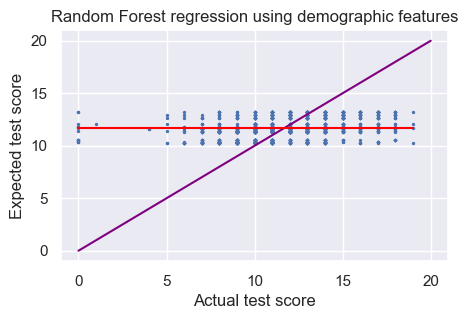

In [66]:
ave_plot(y_train, y_train_pred, 'Random Forest regression using demographic features')

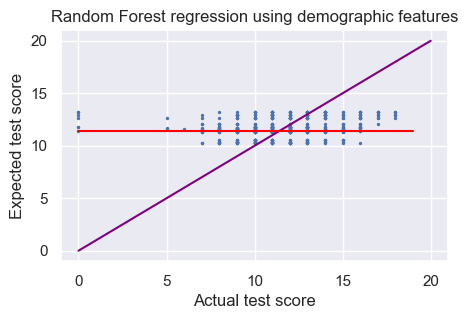

In [67]:
ave_plot(y_test, y_test_pred, 'Random Forest regression using demographic features')

#### XGBoost regression (with fewer features)

Since bagging didn't produce the best results, I'll also try boosting, another method to reduce overfitting. 

Here, a large number of weak learners are trained, where each model learns from the mistakes of the previous one. These weak models are then combined into a strong learner.

In [68]:
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('xgb', XGBRegressor())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.18 or more with any of the target variables is used. R² score achieved is 0.005522713015867005


In [69]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[dem_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800


In [70]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [72]:
pipe = Pipeline([('xgb', XGBRegressor())])


In [73]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [74]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [75]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost regression demographic feat_sel')



XGBoost regression demographic feat_sel training dataset R²: 0.08534922527440836
XGBoost regression demographic feat_sel training dataset MAE: 2.2079153381420915

XGBoost regression demographic feat_sel test dataset R²: 0.005522713015867005
XGBoost regression demographic feat_sel test dataset MAE: 2.0670152753896263


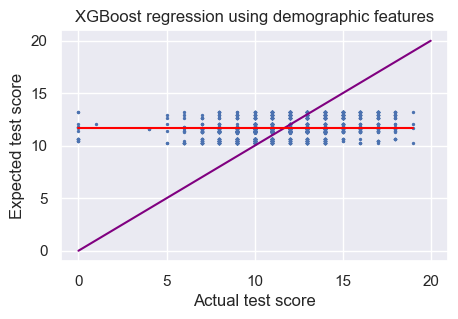

In [76]:
ave_plot(y_train, y_train_pred, 'XGBoost regression using demographic features')

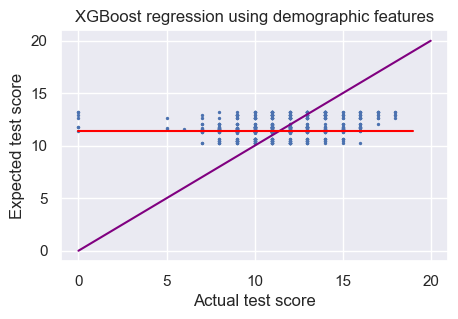

In [77]:
ave_plot(y_test, y_test_pred, 'XGBoost regression using demographic features')

Based on a few different variations on models that I've tried, it seems that demographic factors aren't very predictive of school test scores. 

The models I trained using demographic factors did not explain the variation observed in the school test scores well. With a few of the models, demographic factors actually predicted the test scores worse than simply taking the mean test score as a prediction.

Mother's education level and father's education level were also positively correlated with one another i.e. the more highly educated a person's mother is, the more highly educated the person's father is likely to be.



The only demographic that might be predictive of school test results were mother's education level and father's education level. I've calculated some basic stats and provided some visualisations about these below:


##### Basic stats


Mother's education level in particular had a positive correlation coefficient of 0.2 or higher with all three test scores. 

In [78]:
corr[['G1', 'G2', 'G3']].loc['Medu'].mean()

0.25488611527807964

In [79]:
corr[['G1', 'G2', 'G3']].loc['Fedu'].mean()

0.21814641980471525

Mother's education level and father's education level were also positively correlated with one another i.e. the more highly educated a person's mother is, the more highly educated the person's father is likely to be.


In [80]:
corr['Medu'].loc['Fedu']

0.6474766091364943

###### Visualisations

I’ve included a couple of charts here that show the relationship between parental education level and G1 and G3, the first and third of the test scores provided. 

It looks like for education levels 1-4, there is a clear positive correlation between education level and test score. 

However, the variation in test score for education level 0 is huge. It’s possible that education level has been encoded as 0 when there is no data available for the parental education level. It would be useful to investigate this further before drawing any firm conclusions about either of these features. 

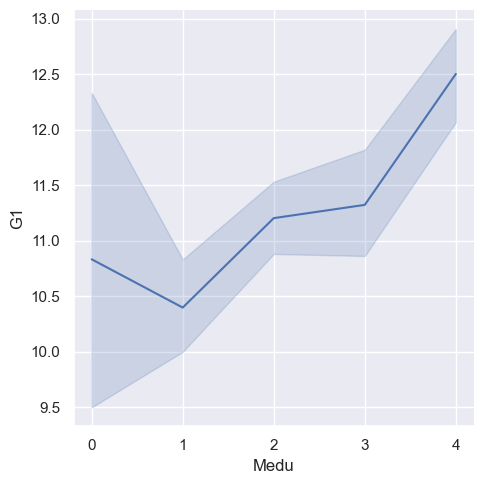

In [81]:
sns.relplot(data=df, x='Medu', y='G1', kind='line')

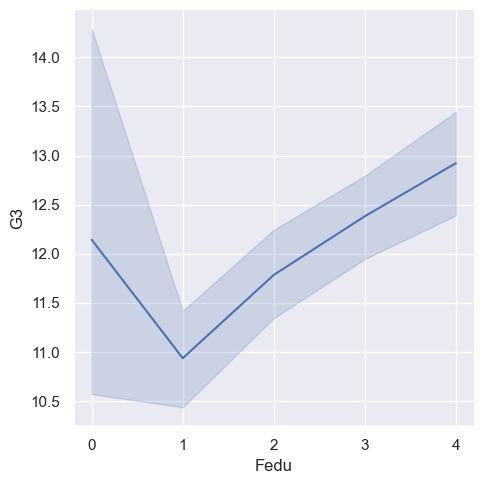

In [82]:
sns.relplot(data=df, x='Fedu', y='G3', kind='line')

### What drives school test results?

The aim here is to see whether other, non-demographic features such as school features and behavioural features impact school test results. Since only mother's education level and father's education level were found to be at all predictive of school test scores, these are the only demographic variables I'll include here.

In [83]:
all_feats = ['schoolsup', #school educational support
             'school_GP',
             'school_MS',
             'reason_course', #reason for choosing school: course
             'reason_home', #reason for choosing school: home
             'reason_reputation', #reason for choosing school: reputation
             'higher', #want to try higher education
             'traveltime', #travel time to school
             'studytime',
             'absences', #absences at school
             'failures', #failures in previous schoolwork or tests
             'paid', #whether they have paid tuition
             'activities', #whether they do extra-curricular activities
             'romantic', #whether they are in a romantic relationship
             'freetime', #how much free time they have after school
             'goout', #how much they go out with their friends
             'Dalc', #daily alcohol consumption
             'Walc', #weekly alcohol consumption
             'Medu',
             'Fedu'
                ]

#### Baseline model

In [84]:
df.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'school_GP', 'school_MS',
       'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3',
       'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_reputation', 'guardian_father', 'guardian_mother'],
      dtype='object')

In [85]:
X = df[all_feats]
y = df[['G1', 'G2', 'G3']]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [87]:
pipe = Pipeline([('lr', LinearRegression())])


In [88]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('lr', LinearRegression())])

In [89]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [90]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled non_demographic')



Linear regression scaled non_demographic training dataset R²: 0.3535862382189985
Linear regression scaled non_demographic training dataset MAE: 1.834483176824077

Linear regression scaled non_demographic test dataset R²: 0.21160213975024358
Linear regression scaled non_demographic test dataset MAE: 1.8414429399199461


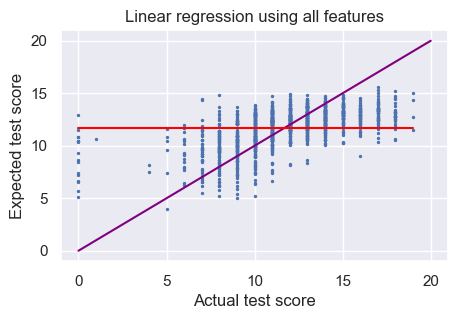

In [91]:
ave_plot(y_train, y_train_pred, 'Linear regression using all features')

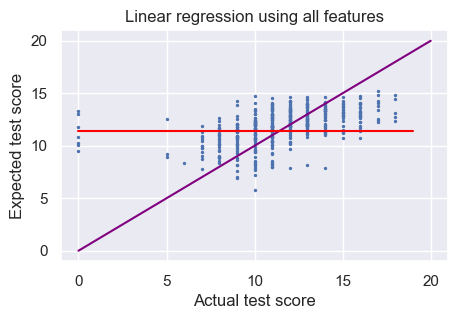

In [92]:
ave_plot(y_test, y_test_pred, 'Linear regression using all features')

#### Linear regression (with scaling)

In [93]:
X = df[all_feats]
y = df[['G1', 'G2', 'G3']]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [95]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [96]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [97]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [98]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled all')



Linear regression scaled all training dataset R²: 0.3535862382189981
Linear regression scaled all training dataset MAE: 1.8344831768240775

Linear regression scaled all test dataset R²: 0.21160213975024303
Linear regression scaled all test dataset MAE: 1.8414429399199468


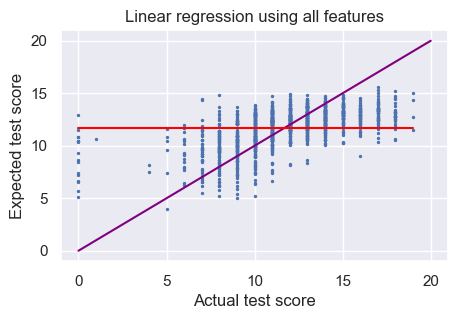

In [99]:
ave_plot(y_train, y_train_pred, 'Linear regression using all features')

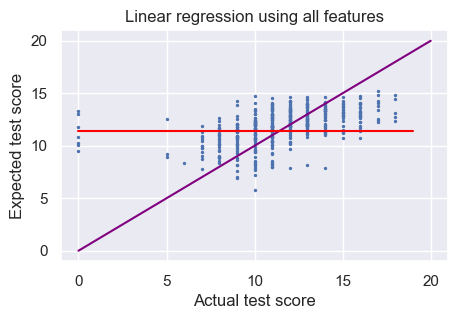

In [100]:
ave_plot(y_test, y_test_pred, 'Linear regression using all features')

#### Linear regression (with feature selection and scaling)

Feature selection is used here to remove highly correlated features and duplicated features.

In [101]:
X = df[set(all_feats)-set(high_corr_cols)-set(duplicated_cols)]
y = df[['G1', 'G2', 'G3']]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [103]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [104]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [105]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [106]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled non_demographic feat_sel')



Linear regression scaled non_demographic feat_sel training dataset R²: 0.35064194656802883
Linear regression scaled non_demographic feat_sel training dataset MAE: 1.8381685683824323

Linear regression scaled non_demographic feat_sel test dataset R²: 0.20146721739896942
Linear regression scaled non_demographic feat_sel test dataset MAE: 1.854651831031462


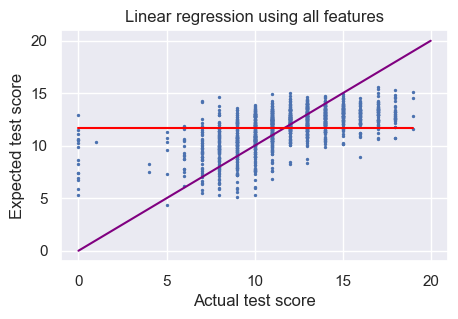

In [107]:
ave_plot(y_train, y_train_pred, 'Linear regression using all features')

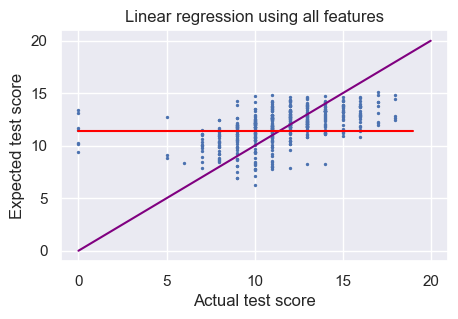

In [108]:
ave_plot(y_test, y_test_pred, 'Linear regression using all features')

#### Linear regression (with selection of fewer features and scaling)

The model appears to be overfitting. I'll attempt to reduce this by using far fewer features.

In [109]:
#find best threshold to use for selecting features based on their correlation coefficient with the target variable
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('lr', LinearRegression())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.0 or more with any of the target variables is used. R² score achieved is 0.20146721739896936


In [110]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
failures,0.384210,0.385782,0.393316
higher,0.349030,0.331953,0.332172
school_GP,0.292626,0.269776,0.284294
school_MS,0.292626,0.269776,0.284294
studytime,0.260875,0.240498,0.249789
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800
Dalc,0.195171,0.189480,0.204719
reason_reputation,0.177441,0.185756,0.170944
Walc,0.155649,0.164852,0.176619


In [111]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [113]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LinearRegression())])


In [114]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [115]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [116]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled non_demographic feat_sel')



Linear regression scaled non_demographic feat_sel training dataset R²: 0.35064194656802883
Linear regression scaled non_demographic feat_sel training dataset MAE: 1.8381685683824323

Linear regression scaled non_demographic feat_sel test dataset R²: 0.20146721739896936
Linear regression scaled non_demographic feat_sel test dataset MAE: 1.8546518310314621


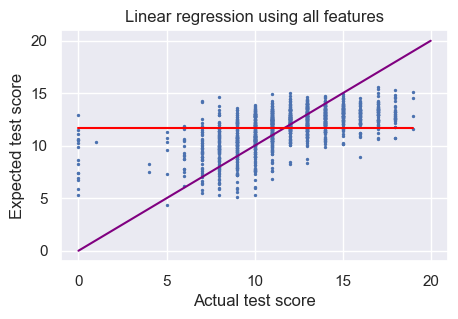

In [117]:
ave_plot(y_train, y_train_pred, 'Linear regression using all features')

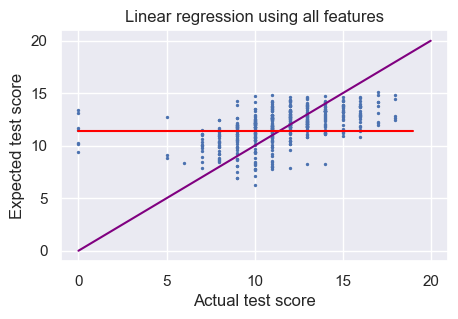

In [118]:
ave_plot(y_test, y_test_pred, 'Linear regression using all features')

#### Linear regression (with fewer features, scaling and L2 regularization)

Although the R<sup>2</sup> score on the test set has improved, the model still appears to be overfitting. I'll attempt to fix this using L2 regularization.

In [119]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

r2_scores = []
alpha = []

for i in range(1, 9):
    pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha = i * 0.25))])
    pipe.fit(X_train, y_train)
    r2 = r2_score(y_test, pipe.predict(X_test))
    r2_scores.append(r2)
    alpha.append(i * 0.25)
    print(f'alpha {alpha[-1]}, R\u00b2 {round(r2, 5)}')

alpha 0.25, R² 0.2015
alpha 0.5, R² 0.20153
alpha 0.75, R² 0.20156
alpha 1.0, R² 0.20159
alpha 1.25, R² 0.20162
alpha 1.5, R² 0.20165
alpha 1.75, R² 0.20168
alpha 2.0, R² 0.20171


Using L2 regularization seems to have only marginally improved our R<sup>2</sup> score compared to the linear regression model with only one feature and scaling.

#### XGBoost regression (with fewer features)

I'll also try boosting, another method to reduce overfitting. 

Here, a large number of weak learners are trained, where each model learns from the mistakes of the previous one. These weak models are then combined into a strong learner.

In [120]:
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('xgb', XGBRegressor())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.06 or more with any of the target variables is used. R² score achieved is 0.052830156060972744


In [121]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
failures,0.384210,0.385782,0.393316
higher,0.349030,0.331953,0.332172
school_GP,0.292626,0.269776,0.284294
school_MS,0.292626,0.269776,0.284294
studytime,0.260875,0.240498,0.249789
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800
Dalc,0.195171,0.189480,0.204719
reason_reputation,0.177441,0.185756,0.170944
Walc,0.155649,0.164852,0.176619


In [122]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [124]:
pipe = Pipeline([('xgb', XGBRegressor())])


In [125]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [126]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [127]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression scaled non_demographic feat_sel')



Linear regression scaled non_demographic feat_sel training dataset R²: 0.9871706084283525
Linear regression scaled non_demographic feat_sel training dataset MAE: 0.1705615255111044

Linear regression scaled non_demographic feat_sel test dataset R²: 0.052830156060972744
Linear regression scaled non_demographic feat_sel test dataset MAE: 2.068374945342175


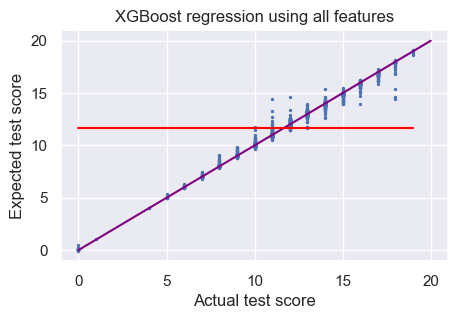

In [128]:
ave_plot(y_train, y_train_pred, 'XGBoost regression using all features')

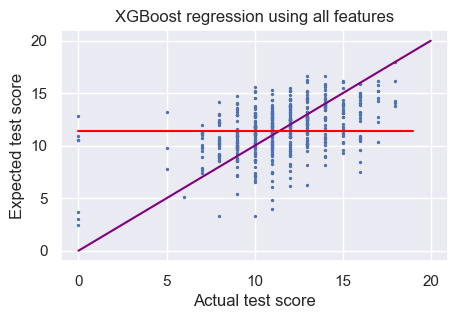

In [129]:
ave_plot(y_test, y_test_pred, 'XGBoost regression using all features')

#### Random Forest regression (with fewer features)

I'll also try bagging, another method to reduce overfitting. Here, a large number of strong learners are trained in parallel, then combined them to smooth out predictions.

In [130]:
#find best threshold to use for selecting features based on their correlation coefficient with the target variables
best_r2 = (0, 0)
for i in range(0, 22):
    corr_threshold = i/100

    sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
    sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
    sel_feats

    X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
    y = df[['G1', 'G2', 'G3']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

    pipe = Pipeline([('rf', RandomForestRegressor())])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_test_pred)
    if r2 > best_r2[1]:
        best_r2 = (corr_threshold, r2)
    
print(f'Best R\u00b2 score achieved when only features with a correlation coefficient of {best_r2[0]} or more with any of the target variables is used. R\u00b2 score achieved is {best_r2[1]}')

Best R² score achieved when only features with a correlation coefficient of 0.06 or more with any of the target variables is used. R² score achieved is 0.21206244534006366


In [131]:
corr_threshold = best_r2[0]
sel_feats = corr.loc[all_feats][['G1', 'G2', 'G3']].abs().sort_values(by=['G1', 'G2', 'G3'], ascending=False)
sel_feats = sel_feats[ (sel_feats['G1']>=corr_threshold) | (sel_feats['G2']>=corr_threshold) | (sel_feats['G3']>=corr_threshold)]
sel_feats

,G1,G2,G3
failures,0.384210,0.385782,0.393316
higher,0.349030,0.331953,0.332172
school_GP,0.292626,0.269776,0.284294
school_MS,0.292626,0.269776,0.284294
studytime,0.260875,0.240498,0.249789
Medu,0.260472,0.264035,0.240151
Fedu,0.217501,0.225139,0.211800
Dalc,0.195171,0.189480,0.204719
reason_reputation,0.177441,0.185756,0.170944
Walc,0.155649,0.164852,0.176619


In [132]:
X = df[[col for col in sel_feats.index if col not in high_corr_cols+duplicated_cols]]
y = df[['G1', 'G2', 'G3']]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [134]:
pipe = Pipeline([('rf', RandomForestRegressor())])


In [135]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestRegressor())])

In [136]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [137]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred, 'Random forest regression all feat_sel')



Random forest regression all feat_sel training dataset R²: 0.8945167473193453
Random forest regression all feat_sel training dataset MAE: 0.7409626363576982

Random forest regression all feat_sel test dataset R²: 0.16390181471978005
Random forest regression all feat_sel test dataset MAE: 1.9656138377641446


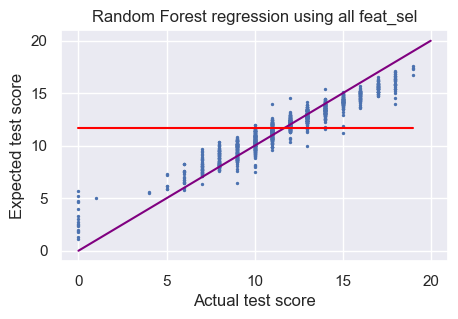

In [138]:
ave_plot(y_train, y_train_pred, 'Random Forest regression using all feat_sel')

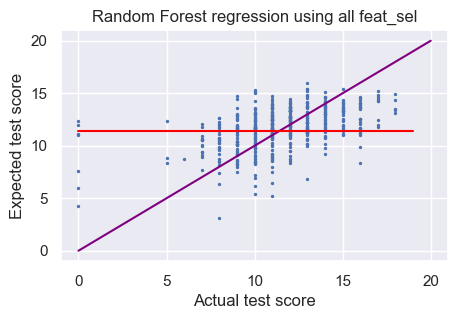

In [139]:
ave_plot(y_test, y_test_pred, 'Random Forest regression using all feat_sel')

#### Model interpretability

Overall, bagging using Random Forest regression seemed to produce the best results, with a mean absolute error of only 2.76 (less than the standard deviation for the dataset, 3.84) and an R<sup>2</sup> of 0.11.


R<sup>2</sup> tended to be higher for models built using both non-demographic factors and demographic factors. This indicates that more of the variation in the test results was exlained by models built using non-demographic and demographic factors. However, the overall accuracy (MAE and R<sup>2</sup>) of the models was still very low. 

This again looks to be due to overfitting, likely because the dataset contains several features but not very many rows. As a result, I'd want to verify these conclusions using more data before presenting them with certainty. 


###### SHAP plots

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

The plots below indicate how important the features 'failures', 'Medu' and 'schoolsup' were in predicting school test results. The x-axis, `mean(|SHAP value|)`, can be considered a general measure of feature importance.

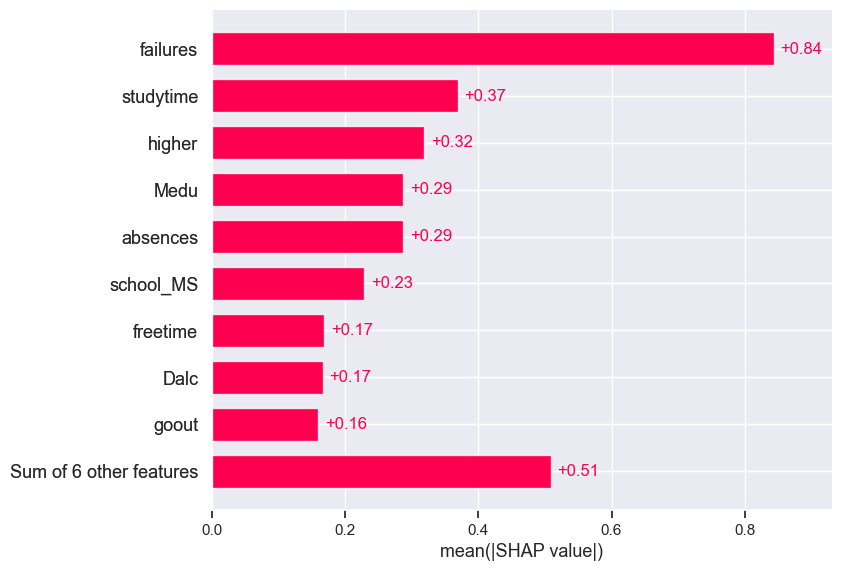

In [140]:
#there seems to be an issue with shap at the moment, so I'm using the following workaround
explainer = shap.TreeExplainer(pipe['rf'])
shap_values1 = explainer(X_train)
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

shap.plots.bar(shap_values2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


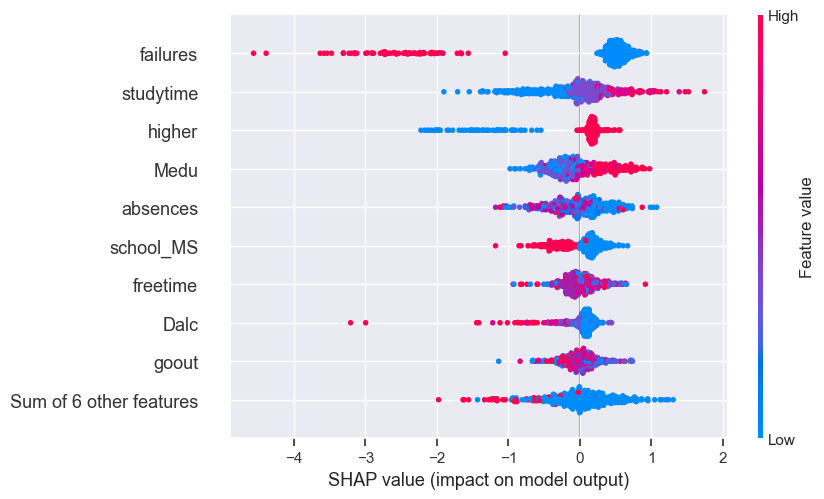

In [141]:
shap.plots.beeswarm(shap_values2)

In addition to mother's education level and father's education level, the features 'failures' and 'schoolsup' appeared to be most predictive of school test scores. I've assumed that 'failures' refers to the number of previous (school) tests they failed on, and 'schoolsup' refers to the amount of support provided by their school. I've provided some visualisations on these below.


###### Visualisations concerning the 'failures' feature

In terms of failures, intuitively it seems to make sense that previous failed (school) tests is negatively correlated with current school test scores. We have to be careful with correlation and causation here – it’s not necessarily true that performing badly on previous tests causes you to perform badly on current tests, but it may be the case that the same external factor caused both of these things. 

In this case, an external factor causing failures to increase and school test scores to decrease could be (for example) lower IQ, poor teaching, lack of study space at home or other responsibilities that mean there is no time to study.

The following bar charts indicate how ‘failures’ affect the three school test scores: in each case, it seems that more failures, or a higher rating on the ‘failures’ scale, indicates lower school test results:

<AxesSubplot: xlabel='failures', ylabel='G1'>

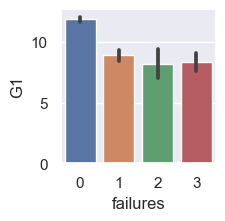

In [142]:
sns.barplot(data=df, x='failures', y='G1')

<AxesSubplot: xlabel='failures', ylabel='G2'>

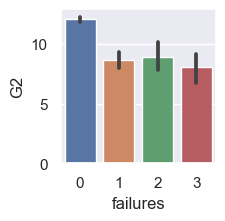

In [143]:
sns.barplot(data=df, x='failures', y='G2')

<AxesSubplot: xlabel='failures', ylabel='G3'>

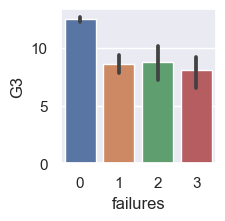

In [144]:
sns.barplot(data=df, x='failures', y='G3')

##### Visualisations concerning the 'schoolsup' feature

Surprisingly, ‘schoolsup’ was also negatively correlated with school test scores, which seems counter-intuitive. 

Being provided support from your school seems likely to influence school test scores, since an educational establishment such as school is probably best placed to provide support for educational tests. I'd want to find out for sure what 'schoolsup' refers to, since my original assumption seems likely to be wrong. 

It is also possible that the school only provides support to students who are really struggling, or perhaps have special educational needs (SEN). Here, again, there could be an external factor that means students are given special support at school, but also perform less well in school tests. If this is the case, it is likely they would perform even worse if they were not given support from their school, so I don’t think this should be considered an indicator that the school support provided is unhelpful. 

The charts here indicate that 'schoolsup' is negatively correlated with all three test scores.

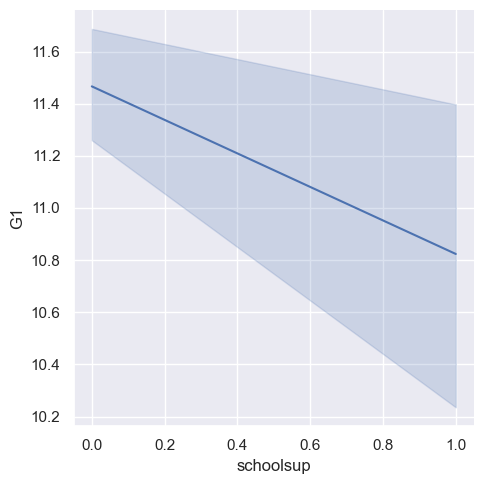

In [145]:
sns.relplot(data=df, x='schoolsup', y='G1', kind='line')

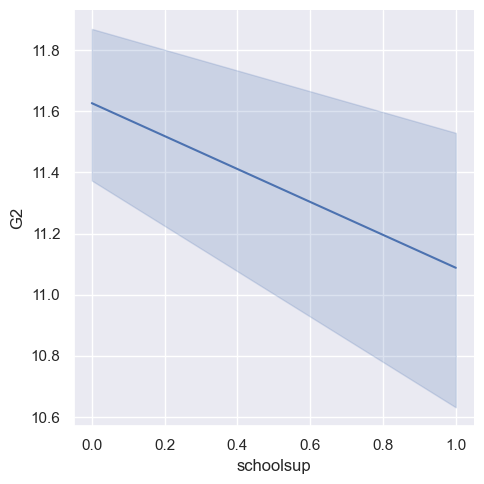

In [146]:
sns.relplot(data=df, x='schoolsup', y='G2', kind='line')

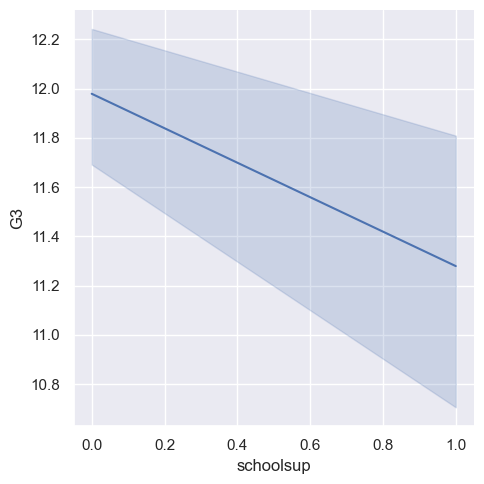

In [147]:
sns.relplot(data=df, x='schoolsup', y='G3', kind='line')

### Conclusion and next steps

It’s important to note that this is quite a small dataset with a large number of features, and the models appeared to be overfitting in most, if not all, cases. 

Overfitting refers to learning the patterns in the training data too well, so that they can make predictions for the training data, but these predictions do not hold up and are not accurate when applied to new data. 

As a result, it’s difficult to train a model which makes accurate predictions on new data, and this happened with all the different models I tried here.  

In future, I’d like to look at a few more techniques for training more accurate models. It would be useful to collect more data, or look at external datasets where school test scores are considered alongside demographic, educational and behavioural information. It would also be useful to experiment further with dimensionality reduction, using techniques other than feature selection according to which features are most highly correlated with the target variables. 

Matrix factorization techniques such as Principal Components Analysis (PCA) could be used to represent most of the variation in the data using just a few components, and the model trained using these components. PCA could also be used to select which features to use in the model: the features which contribute most to the top components account for a large proportion of the variation in the dataset. 

I’d also like to try experimenting more, and in a more systematic way with trials, with the bagging and boosting approaches I tried briefly here, perhaps with different parameters within the models. 